In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import math
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.api import VAR
from arch.unitroot import PhillipsPerron
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [3]:
df=pd.read_csv('data/final_data.csv', index_col=0)
df

,CPI_diff,IIP_diff,IR_diff,MS_diff,STI_diff,NT_diff,FOREX
DATE,,,,,,,
1994-04-01,39.885074,41.227877,-9.00,1092.452818,10.575766,-11.523005,31.3914
1994-05-01,39.678515,41.113347,-8.76,1093.829256,10.984432,-12.429584,31.3754
1994-06-01,39.474888,40.855405,-8.50,1094.445373,9.760103,-12.867327,31.3845
1994-07-01,39.311986,40.696390,-8.50,1098.655610,9.675231,-13.952430,31.3764
1994-08-01,39.316382,40.981120,-8.24,1098.951080,9.249521,-12.811915,31.3727
...,...,...,...,...,...,...,...
2018-08-01,-8.758769,-10.941292,-4.25,3217.072686,-17.850267,-57.911233,69.6317
2018-09-01,-8.635149,-11.682865,-4.00,3240.038646,-14.449065,-59.890798,72.2779
2018-10-01,-8.829508,-15.253146,-4.00,3276.048827,-9.121616,-58.049036,73.5609


<h2>Scaling the dataset</h2>

In [4]:
scaler=MinMaxScaler()
df_scaled = scaler.fit_transform(df.to_numpy())
df_scaled = pd.DataFrame(df_scaled, columns=df.columns,index=df.index)
df_scaled

,CPI_diff,IIP_diff,IR_diff,MS_diff,STI_diff,NT_diff,FOREX
DATE,,,,,,,
1994-04-01,1.000000,0.851994,0.051282,0.041390,0.450665,1.000000,0.000453
1994-05-01,0.995791,0.850267,0.075897,0.041986,0.456269,0.984382,0.000073
1994-06-01,0.991641,0.846376,0.102564,0.042253,0.439480,0.976841,0.000289
1994-07-01,0.988321,0.843977,0.102564,0.044078,0.438316,0.958148,0.000097
1994-08-01,0.988411,0.848272,0.129231,0.044206,0.432479,0.977796,0.000009
...,...,...,...,...,...,...,...
2018-08-01,0.008724,0.065043,0.538462,0.962069,0.060870,0.200862,0.906866
2018-09-01,0.011243,0.053856,0.564103,0.972021,0.107509,0.166759,0.969589
2018-10-01,0.007282,0.000000,0.564103,0.987626,0.180563,0.198488,1.000000


<h2>Checking for Granger Causality</h2>

In [5]:
n_obs=30
X_train, X_test = df_scaled[0:-n_obs], df_scaled[-n_obs:]
print(X_train.shape, X_test.shape)

(267, 7) (30, 7)


In [6]:
rawData = df_scaled.dropna()
model = VAR(rawData) #recall that rawData is w/o difference operation
for i in range(1,13):
    result = model.fit(i)
    try:
        print('Lag Order =', i)
        print('AIC : ', result.aic)
        print('BIC : ', result.bic)
        print('FPE : ', result.fpe)
        print('HQIC: ', result.hqic, '\n')
    except:
        continue

Lag Order = 1
AIC :  -53.2648975872819
BIC :  -52.56672147430167
FPE :  7.368666953072695e-24
HQIC:  -52.98536169896061 

Lag Order = 2
AIC :  -53.897747998145356
BIC :  -52.58543473571932
FPE :  3.915365512296054e-24
HQIC:  -53.372264973242146 

Lag Order = 3
AIC :  -53.849845110625594
BIC :  -51.920350946781525
FPE :  4.113026386627178e-24
HQIC:  -53.077140917827734 

Lag Order = 4
AIC :  -53.87260537068484
BIC :  -51.32286120812353
FPE :  4.030894972912022e-24
HQIC:  -52.85139534269778 

Lag Order = 5
AIC :  -53.83321772281151
BIC :  -50.66012882496354
FPE :  4.210789918187726e-24
HQIC:  -52.56220643493981 

Lag Order = 6
AIC :  -53.73366402186747
BIC :  -49.93410971458699
FPE :  4.681578855560232e-24
HQIC:  -52.21154516884605 

Lag Order = 7
AIC :  -53.70546168429256
BIC :  -49.27629505310917
FPE :  4.859493935505149e-24
HQIC:  -51.93091795533811 

Lag Order = 8
AIC :  -53.62686380862627
BIC :  -48.5649113914745
FPE :  5.321964873184914e-24
HQIC:  -51.59856676067779 

Lag Order = 9

/opt/homebrew/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<h3>p=4 based on AIC</h3>

In [7]:
model = VAR(X_train)
results = model.fit(4)

/opt/homebrew/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


In [8]:
out = durbin_watson(results.resid)

for col, val in zip(df_scaled.columns, out):
    print(col, ':', round(val, 2))

CPI_diff : 1.98
IIP_diff : 2.0
IR_diff : 1.96
MS_diff : 2.03
STI_diff : 1.97
NT_diff : 2.04
FOREX : 1.98


In [9]:
import statsmodels.tsa.stattools as ts 
result=ts.coint(df_scaled['CPI_diff'], df_scaled['FOREX'])
print(result)

(-2.251825620917979, 0.3978212581680254, array([-3.93382232, -3.3568501 , -3.05880942]))


In [10]:
maxlag=4 #becuase we got this value before. We are not suppose to add 1 to it
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

gr = grangers_causation_matrix(X_train, variables = X_train.columns)
gr

,CPI_diff_x,IIP_diff_x,IR_diff_x,MS_diff_x,STI_diff_x,NT_diff_x,FOREX_x
CPI_diff_y,1.0000,0.0003,0.1371,0.0000,0.0003,0.1667,0.0131
IIP_diff_y,0.1211,1.0000,0.0085,0.3202,0.0382,0.0003,0.1836
IR_diff_y,0.1315,0.0000,1.0000,0.0224,0.0506,0.1578,0.1621
MS_diff_y,0.0001,0.0003,0.1902,1.0000,0.1485,0.0001,0.3076
STI_diff_y,0.1293,0.0001,0.0905,0.0133,1.0000,0.0129,0.0232
NT_diff_y,0.0035,0.0014,0.4800,0.0025,0.1815,1.0000,0.0123
FOREX_y,0.0003,0.0003,0.0394,0.0070,0.0078,0.0428,1.0000


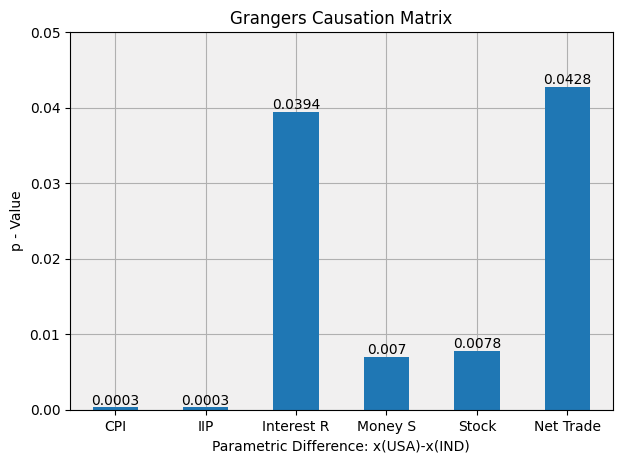

In [11]:
row=gr.loc['FOREX_y'][:-1]
fig=plt.figure(figsize=(7,5), dpi=100)
ax=row.plot(kind='bar',title='Grangers Causation Matrix',xlabel='Parametric Difference: x(USA)-x(IND)',
            ylabel='p - Value')
ax.set_xticklabels(['CPI','IIP','Interest R','Money S','Stock','Net Trade'],rotation=0)
ax.set_facecolor('#f1f0f0')
for container in ax.containers:
    ax.bar_label(container)
ax.set_axisbelow(True)
ax.set_ylim([0.00,0.05])
plt.grid()
plt.show()

<h2>VAR Model</h2>

In [12]:
n_obs=30
X_train, X_test = df_scaled[0:-n_obs], df_scaled[-n_obs:]
print(X_train.shape, X_test.shape)

(267, 7) (30, 7)


In [13]:
transform_data=X_train.diff().dropna()
transform_data

,CPI_diff,IIP_diff,IR_diff,MS_diff,STI_diff,NT_diff,FOREX
DATE,,,,,,,
1994-05-01,-0.004209,-0.001728,0.024615,0.000596,0.005604,-0.015618,-0.000379
1994-06-01,-0.004150,-0.003891,0.026667,0.000267,-0.016789,-0.007541,0.000216
1994-07-01,-0.003320,-0.002399,0.000000,0.001824,-0.001164,-0.018693,-0.000192
1994-08-01,0.000090,0.004295,0.026667,0.000128,-0.005838,0.019648,-0.000088
1994-09-01,-0.003320,0.001410,0.024615,-0.000084,-0.003140,-0.010227,-0.000009
...,...,...,...,...,...,...,...
2016-02-01,0.017267,-0.004294,0.000000,0.013368,0.040745,-0.044951,0.021482
2016-03-01,0.000983,-0.023264,0.000000,0.005236,0.023393,0.067011,-0.031966
2016-04-01,-0.013679,-0.011513,0.076923,0.012504,0.004832,-0.001170,-0.011117


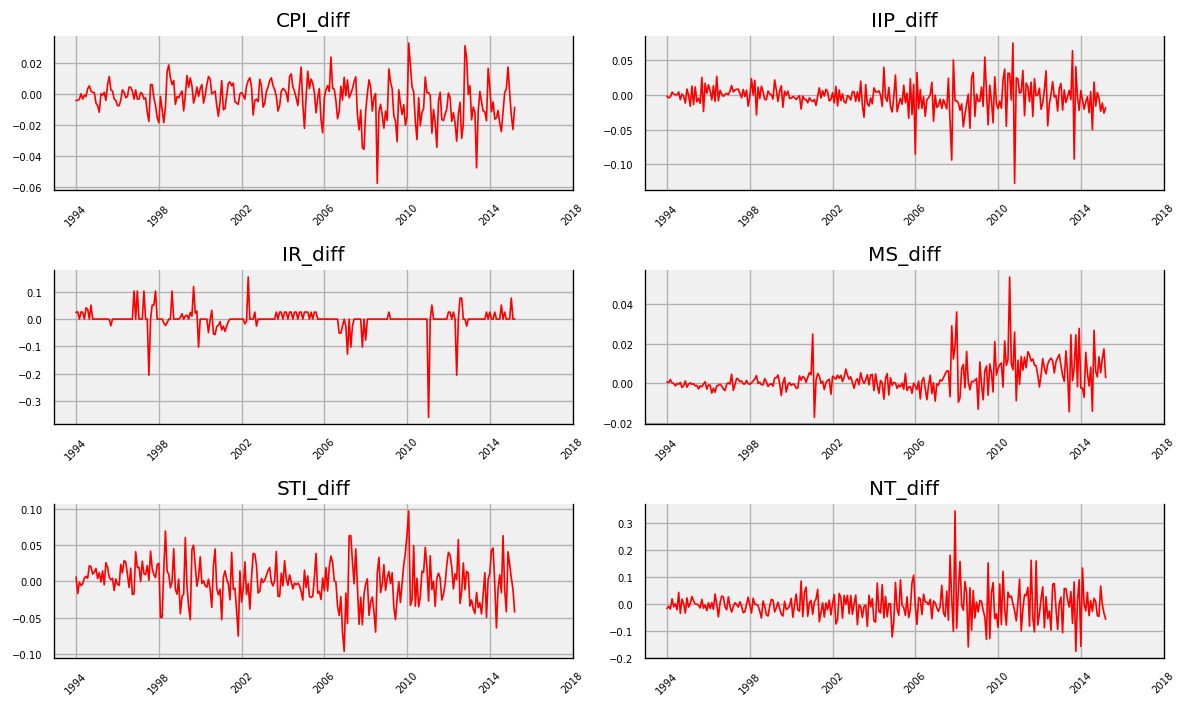

In [14]:
fig, axes = plt.subplots(nrows=3, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = transform_data[transform_data.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    ax.set_facecolor('#f1f0f0')
    labels=['1994','1998','2002','2006','2010','2014','2018']
    xt=[0,50,100,150,200,250, 300]
    ax.set_xticks(xt)
    ax.set_xticklabels(labels,rotation=45)
    ax.set_title(transform_data.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)
    ax.grid()
    plt.tight_layout()

In [15]:
model = VAR(transform_data)
results = model.fit(maxlags=4)
print(results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 06, Nov, 2021
Time:                     16:39:18
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                   -51.6095
Nobs:                     262.000    HQIC:                  -53.2631
Log likelihood:           4723.70    FPE:                2.44514e-24
AIC:                     -54.3743    Det(Omega_mle):     1.17263e-24
--------------------------------------------------------------------
Results for equation CPI_diff
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const              -0.001183         0.000793           -1.491           0.136
L1.CPI_diff         0.463088         0.064919            7.133           0.000
L1.IIP_diff        -0.010493         0.032377           -0.324   

/opt/homebrew/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


In [16]:
# Get the lag order
lag_order = results.k_ar
print(lag_order)
# Input data for forecasting
input_data = transform_data.values[-lag_order:]
print(input_data)
# forecasting
pred = results.forecast(y=input_data, steps=n_obs)
pred = (pd.DataFrame(pred, index=X_test.index, columns=X_test.columns + '_pred'))
print(pred)

4
[[ 0.00098304 -0.02326423  0.          0.00523633  0.02339289  0.06701092
  -0.03196598]
 [-0.01367902 -0.0115134   0.07692308  0.01250413  0.00483166 -0.00117018
  -0.01111675]
 [-0.02285858 -0.02591666  0.          0.01739717 -0.0108764  -0.0331088
   0.01108356]
 [-0.00880696 -0.01843093  0.          0.00296423 -0.04189547 -0.05524021
   0.00891236]]
            CPI_diff_pred  IIP_diff_pred  IR_diff_pred  MS_diff_pred  \
DATE                                                                   
2016-07-01      -0.008138       0.012096     -0.013592      0.012102   
2016-08-01      -0.009093      -0.007451     -0.031892      0.008988   
2016-09-01      -0.005896      -0.011070      0.005865      0.002431   
2016-10-01       0.000405      -0.002422      0.010182      0.005092   
2016-11-01      -0.002864      -0.004898      0.002110      0.004945   
2016-12-01      -0.004832      -0.001651     -0.001370      0.002396   
2017-01-01      -0.003298      -0.002864      0.000368      0.0045

In [17]:
def invert_transformation(s,pred):
    forecast = pred.copy()
    columns = s.columns
    for col in columns:
        forecast[str(col)+'_pred'] = s[col].iloc[-1] + forecast[str(col)+'_pred'].cumsum()
    return forecast

output = invert_transformation(X_train, pred)
output

,CPI_diff_pred,IIP_diff_pred,IR_diff_pred,MS_diff_pred,STI_diff_pred,NT_diff_pred,FOREX_pred
DATE,,,,,,,
2016-07-01,0.091998,0.112798,0.345382,0.815686,0.284028,0.246125,0.854599
2016-08-01,0.082905,0.105348,0.313490,0.824674,0.280893,0.231696,0.845350
2016-09-01,0.077009,0.094278,0.319355,0.827105,0.296220,0.230638,0.840023
2016-10-01,0.077413,0.091857,0.329536,0.832196,0.304493,0.219815,0.840656
2016-11-01,0.074550,0.086958,0.331646,0.837141,0.302237,0.220010,0.843807
2016-12-01,0.069717,0.085308,0.330276,0.839537,0.304077,0.218039,0.849822
2017-01-01,0.066419,0.082443,0.330644,0.844114,0.307391,0.209810,0.856189
2017-02-01,0.062486,0.078308,0.327988,0.847694,0.306652,0.205734,0.859080
2017-03-01,0.058742,0.076285,0.330227,0.851012,0.306644,0.205777,0.861837


In [18]:
df_pred=scaler.inverse_transform(output)
df_pred=pd.DataFrame(df_pred,columns=output.columns)
df_pred

,CPI_diff_pred,IIP_diff_pred,IR_diff_pred,MS_diff_pred,STI_diff_pred,NT_diff_pred,FOREX_pred
0,-4.672368,-7.775429,-6.132522,2879.268873,-1.576334,-55.283822,67.426642
1,-5.118563,-8.269349,-6.443470,2900.010127,-1.804993,-56.121340,67.036447
2,-5.407905,-9.003194,-6.386291,2905.619263,-0.687261,-56.182801,66.811675
3,-5.388039,-9.163723,-6.287021,2917.369401,-0.083922,-56.811042,66.838399
4,-5.528565,-9.488430,-6.266450,2928.780816,-0.248419,-56.799736,66.971334
5,-5.765698,-9.597857,-6.279811,2934.308888,-0.114228,-56.914105,67.225096
6,-5.927546,-9.787742,-6.276221,2944.870211,0.127414,-57.391820,67.493726
7,-6.120536,-10.061892,-6.302119,2953.131509,0.073550,-57.628388,67.615682
8,-6.304267,-10.195986,-6.280286,2960.790307,0.072953,-57.625897,67.731983
9,-6.472769,-10.345988,-6.277731,2970.042089,-0.016621,-57.748226,67.893252


In [19]:
print("MAE :", mean_absolute_error(df['FOREX'][-30:],df_pred['FOREX_pred'][-30:]))
print("RMSE :", math.sqrt(mean_squared_error(df['FOREX'][-30:],df_pred['FOREX_pred'][-30:])))

MAE : 2.407974179360605
RMSE : 2.9798225670450162


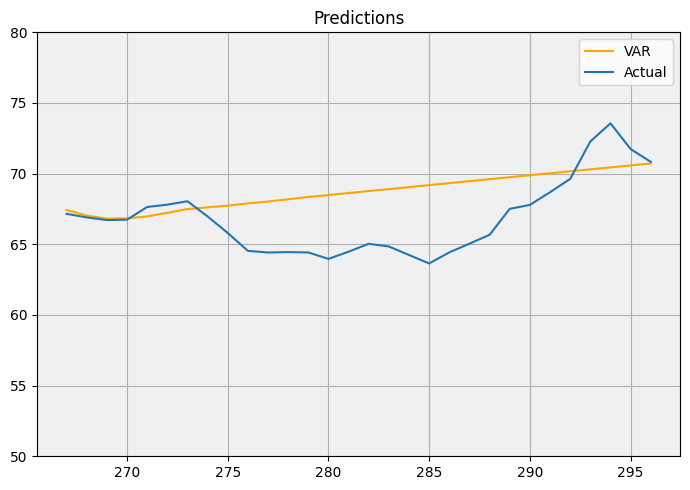

In [20]:
pred=df_pred.FOREX_pred
actual=df.reset_index().FOREX[-30:]
var_pred=pred
pred.index=df.reset_index().FOREX[-30:].index
fig=plt.figure(figsize=(7,5), dpi=100)
ax=pred.plot(color='orange')
ax.plot(actual)
ax.set_ylim([50,80])
ax.legend(['VAR','Actual'])
ax.set_facecolor('#f1f0f0')
ax.grid()
ax.set_title('Predictions')
plt.tight_layout()


<h2>Converting the time series to a supervised ML form</h2>

In [22]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

df_input=series_to_supervised(df_scaled)
df_input.drop(['var1(t)','var2(t)','var3(t)','var4(t)','var5(t)','var6(t)'],axis=1, inplace=True)
df_input.columns=['CPI_diff(t-1)','IIP_diff(t-1)','IR_diff(t-1)','MS_diff(t-1)','STI_diff(t-1)','NT_diff(t-1)','FOREX(t-1)','FOREX(t)']
df_input

,CPI_diff(t-1),IIP_diff(t-1),IR_diff(t-1),MS_diff(t-1),STI_diff(t-1),NT_diff(t-1),FOREX(t-1),FOREX(t)
DATE,,,,,,,,
1994-05-01,1.000000,0.851994,0.051282,0.041390,0.450665,1.000000,0.000453,0.000073
1994-06-01,0.995791,0.850267,0.075897,0.041986,0.456269,0.984382,0.000073,0.000289
1994-07-01,0.991641,0.846376,0.102564,0.042253,0.439480,0.976841,0.000289,0.000097
1994-08-01,0.988321,0.843977,0.102564,0.044078,0.438316,0.958148,0.000097,0.000009
1994-09-01,0.988411,0.848272,0.129231,0.044206,0.432479,0.977796,0.000009,0.000000
...,...,...,...,...,...,...,...,...
2018-08-01,0.007520,0.087211,0.564103,0.956414,0.119842,0.229171,0.884466,0.906866
2018-09-01,0.008724,0.065043,0.538462,0.962069,0.060870,0.200862,0.906866,0.969589
2018-10-01,0.011243,0.053856,0.564103,0.972021,0.107509,0.166759,0.969589,1.000000


<h2>SVM Model </h2>

In [23]:
X=df_input.drop('FOREX(t)',axis=1)
y=df_input['FOREX(t)']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)
print(X_train.shape,y_train.shape)

(266, 7) (266,)


In [24]:
parameters = {'kernel': ('rbf','poly'), 
              'C':[1,1.5,2,3,10,50,100,1000],
              'gamma': [1e-2,1e-3,1e-7, 1e-4]}
#               'epsilon':[0.01,0.05,0.1,0.2,0.5,0.3]}
svr = SVR()
clf = GridSearchCV(svr, parameters)
clf.fit(X_train,y_train)
clf.best_params_

{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}

In [25]:
regressor = SVR(C=1000,kernel = 'rbf',gamma=0.001)
regressor.fit(X_train, y_train)
y_pred=regressor.predict(X_test)
y_pred

array([0.79737393, 0.79174789, 0.78880052, 0.77962886, 0.78751422,
       0.80911148, 0.80990985, 0.81403836, 0.7971609 , 0.78417536,
       0.76752489, 0.76911455, 0.7668246 , 0.77121983, 0.77385622,
       0.77918708, 0.78645523, 0.7984253 , 0.78745244, 0.78455039,
       0.78825571, 0.78619029, 0.78398871, 0.79734032, 0.80381815,
       0.82314194, 0.83351997, 0.86576962, 0.89138874, 0.86006406])

In [26]:
forex_pred=regressor.predict(X)
forex_pred.shape

(296,)

In [27]:
df_pred=df_scaled.copy()
df_pred=df_pred.iloc[1:]
df_pred['FOREX']=forex_pred
df_pred=scaler.inverse_transform(df_pred)
df_pred = pd.DataFrame(df_pred, columns=df_scaled.columns)
df_pred

,CPI_diff,IIP_diff,IR_diff,MS_diff,STI_diff,NT_diff,FOREX
0,39.678515,41.113347,-8.76,1093.829256,10.984432,-12.429584,35.509532
1,39.474888,40.855405,-8.50,1094.445373,9.760103,-12.867327,35.555826
2,39.311986,40.696390,-8.50,1098.655610,9.675231,-13.952430,35.518516
3,39.316382,40.981120,-8.24,1098.951080,9.249521,-12.811915,35.604854
4,39.153480,41.074576,-8.00,1098.756162,9.020558,-13.405544,35.459004
...,...,...,...,...,...,...,...
291,-8.758769,-10.941292,-4.25,3217.072686,-17.850267,-57.911233,66.099506
292,-8.635149,-11.682865,-4.00,3240.038646,-14.449065,-59.890798,66.537341
293,-8.829508,-15.253146,-4.00,3276.048827,-9.121616,-58.049036,67.897908
294,-9.186866,-11.244841,-4.00,3248.677862,-13.438811,-56.973449,68.978743


In [28]:
print("MAE :", mean_absolute_error(df['FOREX'][-30:],df_pred['FOREX'][-30:]))
print("RMSE :", math.sqrt(mean_squared_error(df['FOREX'][-30:],df_pred['FOREX'][-30:])))

MAE : 1.861924913253904
RMSE : 2.3924865977639955


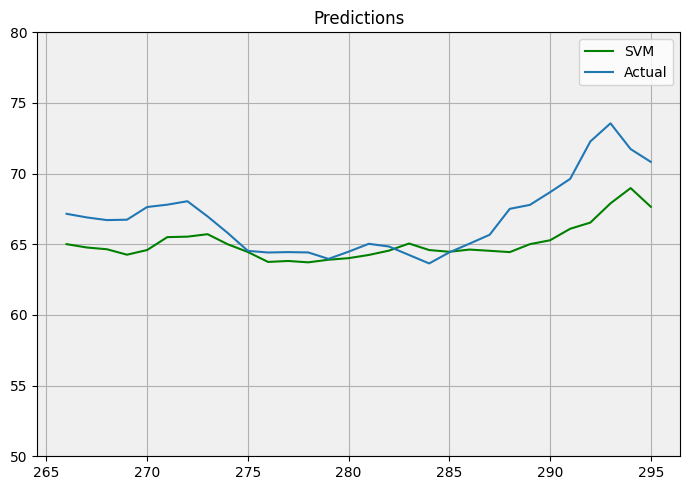

In [29]:
pred=df_pred.FOREX[-30:]
actual=df.iloc[1:].reset_index().FOREX[-30:]
svm_pred=pred
fig=plt.figure(figsize=(7,5), dpi=100)
ax=pred.plot(color='g')
ax.plot(actual)
ax.set_ylim([50,80])
ax.legend(['SVM','Actual'])
ax.set_facecolor('#f1f0f0')
ax.grid()
ax.set_title('Predictions')
plt.tight_layout()

<h2>Random Forest Regressor</h2>

In [30]:
X=df_input.drop('FOREX(t)',axis=1)
y=df_input['FOREX(t)']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)
print(X_train.shape,y_train.shape)

(266, 7) (266,)


In [31]:
rfr=RandomForestRegressor()
rfr.fit(X_train, y_train)
y_pred=regressor.predict(X_test)
y_pred

array([0.79737393, 0.79174789, 0.78880052, 0.77962886, 0.78751422,
       0.80911148, 0.80990985, 0.81403836, 0.7971609 , 0.78417536,
       0.76752489, 0.76911455, 0.7668246 , 0.77121983, 0.77385622,
       0.77918708, 0.78645523, 0.7984253 , 0.78745244, 0.78455039,
       0.78825571, 0.78619029, 0.78398871, 0.79734032, 0.80381815,
       0.82314194, 0.83351997, 0.86576962, 0.89138874, 0.86006406])

In [32]:
forex_pred=rfr.predict(X)
forex_pred.shape

(296,)

In [33]:
df_pred=df_scaled.copy()
df_pred=df_pred.iloc[1:]
df_pred['FOREX']=forex_pred
df_pred=scaler.inverse_transform(df_pred)
df_pred = pd.DataFrame(df_pred, columns=df_scaled.columns)
df_pred

,CPI_diff,IIP_diff,IR_diff,MS_diff,STI_diff,NT_diff,FOREX
0,39.678515,41.113347,-8.76,1093.829256,10.984432,-12.429584,31.423924
1,39.474888,40.855405,-8.50,1094.445373,9.760103,-12.867327,31.418622
2,39.311986,40.696390,-8.50,1098.655610,9.675231,-13.952430,31.380695
3,39.316382,40.981120,-8.24,1098.951080,9.249521,-12.811915,31.399700
4,39.153480,41.074576,-8.00,1098.756162,9.020558,-13.405544,31.380366
...,...,...,...,...,...,...,...
291,-8.758769,-10.941292,-4.25,3217.072686,-17.850267,-57.911233,67.500804
292,-8.635149,-11.682865,-4.00,3240.038646,-14.449065,-59.890798,67.500804
293,-8.829508,-15.253146,-4.00,3276.048827,-9.121616,-58.049036,67.500804
294,-9.186866,-11.244841,-4.00,3248.677862,-13.438811,-56.973449,67.500804


In [34]:
print("MAE :", mean_absolute_error(df['FOREX'][-30:],df_pred['FOREX'][-30:]))
print("RMSE :", math.sqrt(mean_squared_error(df['FOREX'][-30:],df_pred['FOREX'][-30:])))

MAE : 1.9400541000000027
RMSE : 2.408124326290118


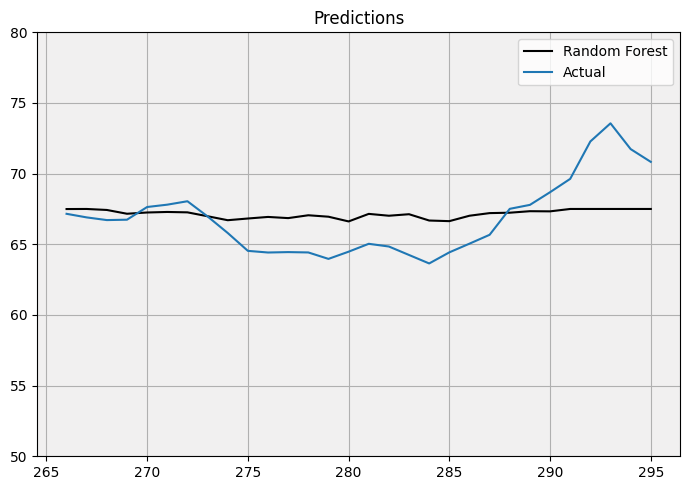

In [35]:
pred=df_pred.FOREX[-30:]
actual=df.iloc[1:].reset_index().FOREX[-30:]
rfr_pred=pred
fig=plt.figure(figsize=(7,5), dpi=100)
ax=pred.plot(color='black')
ax.plot(actual)
ax.set_ylim([50,80])
ax.legend(['Random Forest','Actual'])
ax.set_facecolor('#f1f0f0')
ax.grid()
ax.set_title('Predictions')
plt.tight_layout()

<h2>LSTM RNN Model</h2>

In [36]:
values = df_input.values
n_train_months = 266
train = values[:n_train_months, :]
test = values[n_train_months:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(266, 1, 7) (266,) (30, 1, 7) (30,)


Epoch 1/25
9/9 - 1s - loss: 0.4331 - val_loss: 0.7786
Epoch 2/25
9/9 - 0s - loss: 0.3560 - val_loss: 0.7258
Epoch 3/25
9/9 - 0s - loss: 0.2904 - val_loss: 0.6748
Epoch 4/25
9/9 - 0s - loss: 0.2392 - val_loss: 0.6272
Epoch 5/25
9/9 - 0s - loss: 0.2013 - val_loss: 0.5803
Epoch 6/25
9/9 - 0s - loss: 0.1674 - val_loss: 0.5332
Epoch 7/25
9/9 - 0s - loss: 0.1467 - val_loss: 0.4913
Epoch 8/25
9/9 - 0s - loss: 0.1388 - val_loss: 0.4577
Epoch 9/25
9/9 - 0s - loss: 0.1394 - val_loss: 0.4356
Epoch 10/25
9/9 - 0s - loss: 0.1361 - val_loss: 0.4191
Epoch 11/25
9/9 - 0s - loss: 0.1298 - val_loss: 0.4017
Epoch 12/25
9/9 - 0s - loss: 0.1236 - val_loss: 0.3799
Epoch 13/25
9/9 - 0s - loss: 0.1178 - val_loss: 0.3549
Epoch 14/25
9/9 - 0s - loss: 0.1125 - val_loss: 0.3294
Epoch 15/25
9/9 - 0s - loss: 0.1074 - val_loss: 0.3046
Epoch 16/25
9/9 - 0s - loss: 0.1016 - val_loss: 0.2791
Epoch 17/25
9/9 - 0s - loss: 0.0954 - val_loss: 0.2516
Epoch 18/25
9/9 - 0s - loss: 0.0893 - val_loss: 0.2230
Epoch 19/25
9/9 - 0

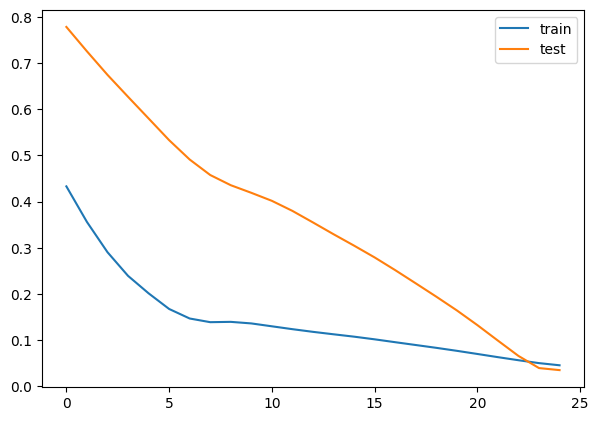

Model: "sequential_58"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_58 (LSTM)               (None, 20)                2240      
_________________________________________________________________
dense_58 (Dense)             (None, 1)                 21        
Total params: 2,261
Trainable params: 2,261
Non-trainable params: 0
_________________________________________________________________


In [150]:
tf.random.set_seed(1234)
# design network
model = Sequential()
model.add(LSTM(20, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=25, batch_size=32, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
fig=plt.figure(figsize=(7,5), dpi=100)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()
model.summary()

In [151]:
y_pred=model.predict(test_X)
df_pred=df_scaled.copy()
df_pred['FOREX'][-30:]=y_pred[:,0]
df_pred=scaler.inverse_transform(df_pred)
df_pred = pd.DataFrame(df_pred, columns=df_scaled.columns)
df_pred

,CPI_diff,IIP_diff,IR_diff,MS_diff,STI_diff,NT_diff,FOREX
0,39.885074,41.227877,-9.00,1092.452818,10.575766,-11.523005,31.391400
1,39.678515,41.113347,-8.76,1093.829256,10.984432,-12.429584,31.375400
2,39.474888,40.855405,-8.50,1094.445373,9.760103,-12.867327,31.384500
3,39.311986,40.696390,-8.50,1098.655610,9.675231,-13.952430,31.376400
4,39.316382,40.981120,-8.24,1098.951080,9.249521,-12.811915,31.372700
...,...,...,...,...,...,...,...
292,-8.758769,-10.941292,-4.25,3217.072686,-17.850267,-57.911233,68.052971
293,-8.635149,-11.682865,-4.00,3240.038646,-14.449065,-59.890798,68.234513
294,-8.829508,-15.253146,-4.00,3276.048827,-9.121616,-58.049036,69.479124
295,-9.186866,-11.244841,-4.00,3248.677862,-13.438811,-56.973449,70.228670


In [152]:
print("MAE :", mean_absolute_error(df['FOREX'][-30:],df_pred['FOREX'][-30:]))
print("RMSE :", math.sqrt(mean_squared_error(df['FOREX'][-30:],df_pred['FOREX'][-30:])))

MAE : 1.4706947515277056
RMSE : 1.698327663541783


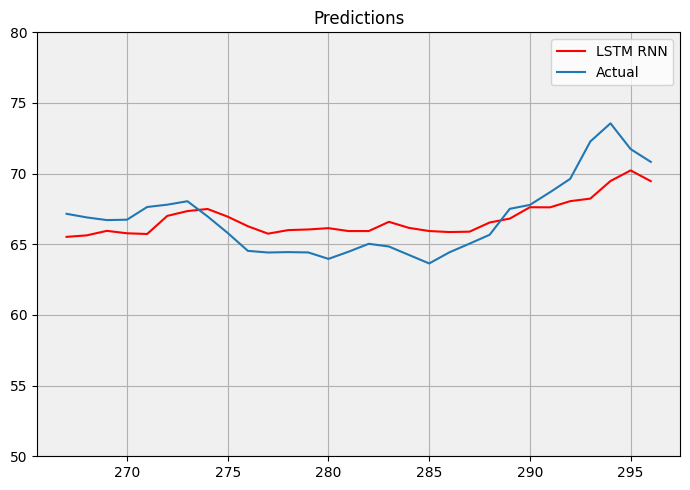

In [153]:
pred=df_pred.FOREX[-30:]
actual=df.reset_index().FOREX[-30:]
lstm_pred=pred
fig=plt.figure(figsize=(7,5), dpi=100)
ax=pred.plot(color='r')
ax.plot(actual)
ax.set_ylim([50,80])
ax.legend(['LSTM RNN','Actual'])
ax.set_facecolor('#f1f0f0')
ax.grid()
ax.set_title('Predictions')
plt.tight_layout()

<h2>Comparing All 4 models</h2>

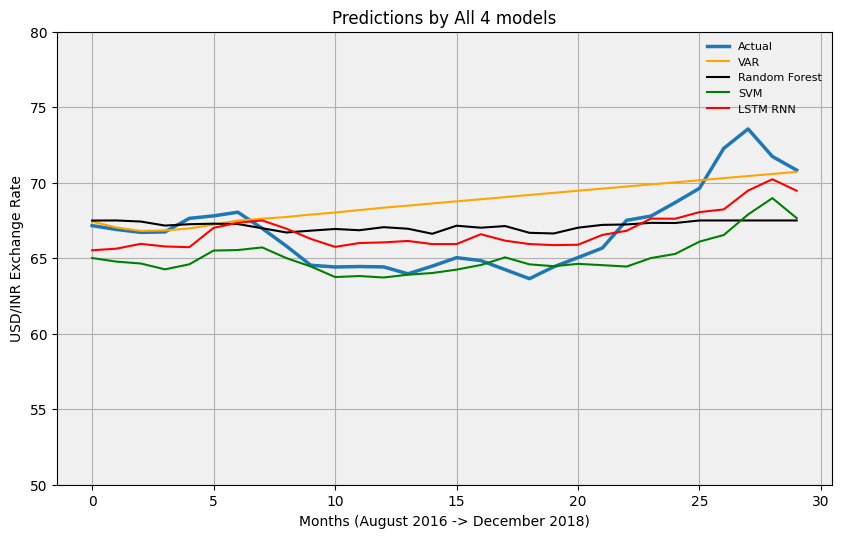

In [154]:
fig,ax=plt.subplots(figsize=(10,6), dpi=100)
ax.set_ylim([50,80])
plt.plot(np.array(actual),linewidth=2.5,)
plt.plot(np.array(var_pred),linewidth=1.5, color='orange')
plt.plot(np.array(rfr_pred),linewidth=1.5, color='black')
plt.plot(np.array(svm_pred),linewidth=1.5, color='green')
plt.plot(np.array(lstm_pred),linewidth=1.5, color='red')
ax.legend(['Actual','VAR','Random Forest','SVM','LSTM RNN'],fontsize=8, framealpha=0)
ax.set_facecolor('#f1f0f0')
ax.grid()
ax.set_title('Predictions by All 4 models')
ax.set_xlabel('Months (August 2016 -> December 2018)')
ax.set_ylabel('USD/INR Exchange Rate')
plt.show()

<h2>Feature Importance Test</h2>

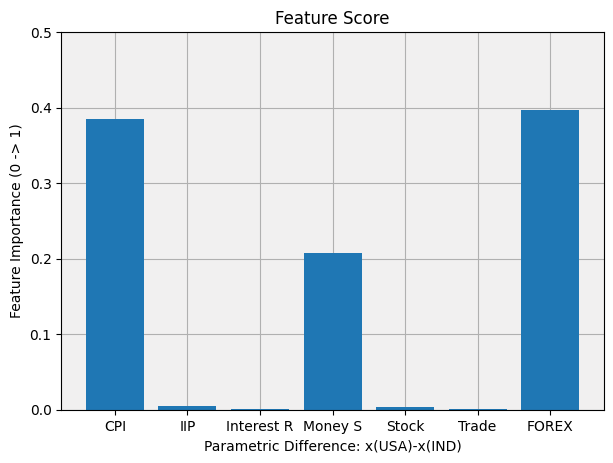

In [124]:
model=RandomForestRegressor(random_state=2)
model.fit(X,y)
importance = model.feature_importances_
row=importance
fig,ax=plt.subplots(figsize=(7,5), dpi=100)
plt.bar(x=['CPI','IIP','Interest R','Money S','Stock','Trade','FOREX'],height=row)
ax.set_facecolor('#f1f0f0')
ax.set_axisbelow(True)
ax.set_ylim([0.0,0.5])
ax.set_title('Feature Score')
ax.set_xlabel('Parametric Difference: x(USA)-x(IND)')
ax.set_ylabel('Feature Importance (0 -> 1)')
plt.grid()
plt.show()

<h2>Feature Correlation</h2>

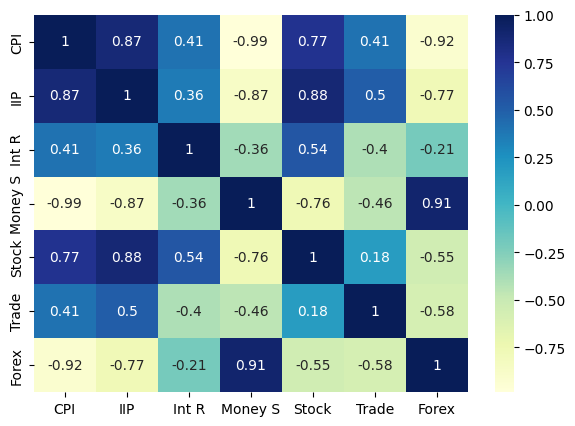

In [125]:
fig,ax=plt.subplots(figsize=(7,5), dpi=100)
cor = df.corr()
cor.columns=cor.index=['CPI','IIP','Int R','Money S','Stock','Trade','Forex']
sns.heatmap(cor, annot=True, cmap="YlGnBu")
plt.show()